# **Transfer Learning with Pytorch Tutorial**

In [2]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

tcmalloc: large alloc 1073750016 bytes == 0x57f50000 @  0x7f81c58682a4 0x594e17 0x626104 0x51190a 0x4f5277 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x4f3338 0x510fb0 0x5119bd 0x4f6070


In [0]:
# initializing all the libraries and dependencies

import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [4]:
!mkdir data && wget https://download.pytorch.org/tutorial/hymenoptera_data.zip

--2018-11-14 18:28:47--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.35.125.93, 13.35.125.19, 13.35.125.80, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.35.125.93|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M  43.7MB/s    in 1.0s    

2018-11-14 18:28:48 (43.7 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]



In [5]:
!unzip "hymenoptera_data.zip"

Archive:  hymenoptera_data.zip
   creating: hymenoptera_data/
   creating: hymenoptera_data/train/
   creating: hymenoptera_data/train/ants/
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera_data/train/ants/116570827_e9c126745d.jpg  
  inflating: hymenoptera_data/train/ants/1225872729_6f0856588f.jpg  
  inflating: hymenoptera_data/train/ants/1262877379_64fcada201.jpg  
  inflating: hymenoptera_data/train/ants/1269756697_0bce92cdab.jpg  
  inflating: hymenoptera_data/train/ants/1286984635_5119e80de1.jpg  
  inflating: hymenoptera_data/train/ants/132478121_2a430adea2.jpg  
  inflating: hymenoptera_data/train/ants/1360291657_dc248c5eea.jpg  
  inflating: hymenoptera_data/train/ants/1368913450_e146e2fb6d.jpg  
  inflating: hymenoptera_data/train/ants/147318

In [0]:
# Data transformation on training and valiation data

data_transforms = {
    'train' : transforms.Compose([
        transforms.RandomResizedCrop(224), transforms.RandomHorizontalFlip(), transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
    ]),
    
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = "hymenoptera_data"

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir,x), data_transforms[x]) for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
#code taken from tutorial

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict()) #copy the state dictionary of the model top keep track of the best model accuracy
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history of gradients if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [0]:
model_ft = models.resnet18(pretrained=True)

#number of in features of resnet model
num_ftrs = model_ft.fc.in_features

#linear layer for bees and ants which is 2, adding fc layer to our convnet
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [24]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5702 Acc: 0.7008
val Loss: 0.2404 Acc: 0.9085

Epoch 1/24
----------
train Loss: 0.3392 Acc: 0.8525
val Loss: 0.4228 Acc: 0.8693

Epoch 2/24
----------
train Loss: 0.6899 Acc: 0.7746
val Loss: 0.3357 Acc: 0.9020

Epoch 3/24
----------
train Loss: 0.7261 Acc: 0.7541
val Loss: 0.2957 Acc: 0.9150

Epoch 4/24
----------
train Loss: 0.4684 Acc: 0.8279
val Loss: 0.7673 Acc: 0.7190

Epoch 5/24
----------
train Loss: 0.4308 Acc: 0.7869
val Loss: 0.3491 Acc: 0.8693

Epoch 6/24
----------
train Loss: 0.5055 Acc: 0.7910
val Loss: 0.2146 Acc: 0.8954

Epoch 7/24
----------
train Loss: 0.3301 Acc: 0.8525
val Loss: 0.2131 Acc: 0.9150

Epoch 8/24
----------
train Loss: 0.3511 Acc: 0.8402
val Loss: 0.2291 Acc: 0.9020

Epoch 9/24
----------
train Loss: 0.3149 Acc: 0.8566
val Loss: 0.2272 Acc: 0.9150

Epoch 10/24
----------
train Loss: 0.3654 Acc: 0.8402
val Loss: 0.2062 Acc: 0.9281

Epoch 11/24
----------
train Loss: 0.2914 Acc: 0.8811
val Loss: 0.2005 Acc: 0.9281

Ep

In [0]:
#helper functions taken from tutorial

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

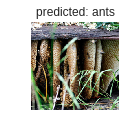

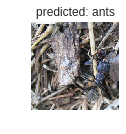

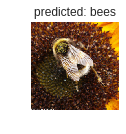

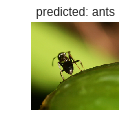

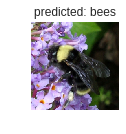

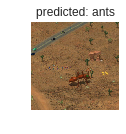

In [26]:
visualize_model(model_ft)